# Robomed

In [58]:
%matplotlib inline

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from fuzzywuzzy import fuzz
from tqdm import tqdm_notebook
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

## Args

In [2]:
TRAIN_PATH = '~/.kaggle/competitions/ai-hack-2018-spb-robomed/train_data.csv'
TEST_PATH = '~/.kaggle/competitions/ai-hack-2018-spb-robomed/test_data.csv'
SUBMISSION_PATH = 'submission.csv'
MODEL_SAVE_PATH = 'model.pkl'

## Read

In [3]:
def initial_pre(df):
    df = df.copy()
    del df['ID']
    rename_map = {
        'Код_диагноза': 'diag_code',
        'Диагноз': 'diag',
        'Возраст': 'age',
        'Пол': 'sex',
        'Общее состояние': 'state',
        'аллергия': 'allergies',
        'Анамнез заболевания': 'anamnesis',
        'Внешний осмотр': 'checkup',
        'Revisit': 'revisit'
    }
    return df.rename(columns=rename_map)

In [4]:
df = initial_pre(pd.read_csv(TRAIN_PATH))
len(df)

283086

In [5]:
df.head()

,diag_code,diag,age,sex,state,allergies,anamnesis,checkup,revisit
0,J06.0,Острый ларингофарингит,29,2,NaN,NaN,NaN,На жевательной поверхности 2.6- кариозная поло...,1
1,N76.1,Подострый и хронический вагинит,45,2,NaN,NaN,считает себя больной на протяжении многих лет....,NaN,1
2,L23.9,"Аллергический контактный дерматит, причина не ...",63,2,NaN,NaN,"Болен около 2-х дней, когда появились описанны...",NaN,1
3,N48.1,Баланопостит,43,2,NaN,не отягощен,NaN,NaN,1
4,Z00.0,Общий медицинский осмотр,29,1,NaN,NaN,провела полное обследование для оперативного л...,NaN,1


In [6]:
df.describe(include='all')

,diag_code,diag,age,sex,state,allergies,anamnesis,checkup,revisit
count,283086,283086,283086.000000,283086.000000,41696,40908,203656,13295,283086.000000
unique,3437,3394,NaN,NaN,2942,5141,152589,779,NaN
top,N77.1*,"Вагинит, вульвит и вульвовагинит при инфекцион...",NaN,NaN,Общее самочувствие удовлетворительное. Кожные ...,не отягощен,консультация по проведенному обследованию и ко...,удовлетворительное.,NaN
freq,11214,11214,NaN,NaN,8960,17361,3025,6622,NaN
mean,NaN,NaN,41.696905,1.708347,NaN,NaN,NaN,NaN,0.828639
std,NaN,NaN,21.540704,0.454524,NaN,NaN,NaN,NaN,0.376825
min,NaN,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,31.000000,1.000000,NaN,NaN,NaN,NaN,1.000000
50%,NaN,NaN,38.000000,2.000000,NaN,NaN,NaN,NaN,1.000000
75%,NaN,NaN,51.000000,2.000000,NaN,NaN,NaN,NaN,1.000000


In [7]:
df.dtypes

diag_code    object
diag         object
age           int64
sex           int64
state        object
allergies    object
anamnesis    object
checkup      object
revisit       int64
dtype: object

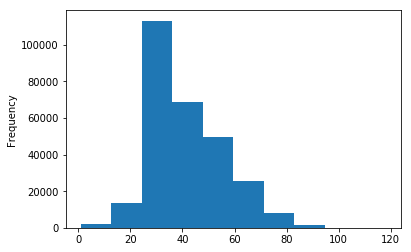

In [8]:
age = df.age.copy()
age[age > 120] = None
age.plot('hist');

## Test analysis

In [9]:
tdf = initial_pre(pd.read_csv(TEST_PATH))
tdf.head()

,diag_code,diag,age,sex,state,allergies,anamnesis,checkup
0,Z39.2,Рутинное послеродовое наблюдение,41,2,Общее самочувствие удовлетворительное. Кожные ...,Аллергию на лекарства - отрицает.,NaN,NaN
1,M54.2,Цервикалгия,64,2,NaN,не отягощен,NaN,NaN
2,M41,Сколиоз,34,2,"Удовлетворительное. Температура тела - 36,6. С...",NaN,NaN,NaN
3,J31.2,Хронический фарингит,58,2,NaN,NaN,NaN,Общее состояние удовлетворительное. Конфигурац...
4,M21.4,Плоская стопа [pes planus] (приобретенная),34,2,NaN,NaN,Жалобы сегодня с утра,NaN


In [10]:
df.sex.value_counts()

2    200523
1     82563
Name: sex, dtype: int64

In [11]:
tdf.sex.value_counts()

2    66391
1    33609
Name: sex, dtype: int64

In [ ]:
# def group_column(df, tdf, column):
#     column = pd.concat([df[column], tdf[column]])

In [69]:
# svc = state.value_counts()
# bins = []
# for s, c in tqdm_notebook(svc.iteritems()):
#     max_id, max_score = None, None
#     for id_, bin_ in enumerate(bins):
#         cur_score = fuzz.ratio(s, bin_[0])
#         if max_score is None or cur_score > max_score:
#             max_id = id_
#             max_score = cur_score
#     if max_id is not None and max_score > 50:
#         bins[max_id].append(s)
#     else:
#         bins.append([s])

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

## Preprocess

### Only `anamnesis`

In [12]:
# def make_textclf_data(df, balance=False):
#     X, y = df.anamnesis.fillna(''), df.revisit
    
#     if balance:
#         n = y.value_counts().min()
#         y0, y1 = y[y == 0].sample(n), y[y == 1].sample(n)
#         X0, X1 = X[y0.index], X[y1.index]
#         X, y = pd.concat([X0, X1], axis=0).sample(frac=1), pd.concat([y0, y1], axis=0).sample(frac=1)
    
#     return X, y

### Features

In [13]:
def parse_diag_code(diag_code, 
                    dc_pattern=re.compile('([A-Z])?([0-9][0-9])?(\.([0-9]))?')):
    m = dc_pattern.match(diag_code)
    letter, code, subcode = m.group(1), m.group(2), m.group(4)
    code = int(code) if code is not None else None
    subcode = int(subcode) if subcode is not None else None
    return letter, code, subcode


# def get_age_group(age):
#     if age > 120:
#         return None
# #     df.age.as_matrix()[:, np.newaxis].shape
#     return 0

In [14]:
class FFTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, sex_1d=None):
        self.sex_1d = sex_1d
    
    def fit(self, df):
        return self
    
    def transform(self, df):
        df = df.copy()
        
        if self.sex_1d:
            n = int((df.sex == 1).sum() / self.sex_1d)
            df1 = df[df.sex == 1]
            df2 = df[df.sex == 2].sample(n)
            df = pd.concat([df1, df2], axis=0)
    
        features = []
        # diag_code
        features.append(pd.DataFrame(list(df.diag_code.apply(parse_diag_code)), 
                                     columns=['letter', 'code', 'subcode'],
                                     dtype=object, index=df.index))
        
        # diag
        features.append(df[['diag']])

        # age
        df.age = df.age.astype(float)
        df.loc[df.age > 120, 'age'] = np.nan
        features.append(df[['age']])

        # sex
        features.append(df[['sex']])

        # state, allergies, checkup, -anamnesis
        features.append(df[['state', 'allergies', 'checkup']])

        data = pd.concat(features, axis=1)
        data = data.apply(lambda c: c.fillna('NaN') if (c.dtype == object) else c)
        if 'revisit' in df:
            data = (data, df.revisit)

        return data

In [15]:
ff = FFTransformer()
X, y = ff.fit_transform(df)
X.head()

,letter,code,subcode,diag,age,sex,state,allergies,checkup
0,J,6,0,Острый ларингофарингит,29.0,2,NaN,NaN,На жевательной поверхности 2.6- кариозная поло...
1,N,76,1,Подострый и хронический вагинит,45.0,2,NaN,NaN,NaN
2,L,23,9,"Аллергический контактный дерматит, причина не ...",63.0,2,NaN,NaN,NaN
3,N,48,1,Баланопостит,43.0,2,NaN,не отягощен,NaN
4,Z,0,0,Общий медицинский осмотр,29.0,1,NaN,NaN,NaN


In [16]:
X.dtypes

letter        object
code           int64
subcode       object
diag          object
age          float64
sex            int64
state         object
allergies     object
checkup       object
dtype: object

In [17]:
y.dtype

dtype('int64')

## TT split

In [18]:
preprocess = FFTransformer()
X, y = preprocess.fit_transform(df)
cat_features = np.where(X.dtypes != np.float)[0]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)
X_test = preprocess.transform(tdf)
X_train.shape, X_val.shape, X_test.shape

((254777, 9), (28309, 9), (100000, 9))

## Scipy

In [19]:
# from sklearn.pipeline import Pipeline
# from sklearn.linear_model import SGDClassifier
# from sklearn.neural_network import MLPClassifier
# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [20]:
# model = Pipeline([
#     ('vec', TfidfVectorizer(ngram_range=(1, 3), max_features=1000)),
#     ('clf', MLPClassifier(hidden_layer_sizes=(300, 300, 2))),
#  ])

In [21]:
# %time model.fit(X_train, y_train)

In [22]:
# y_pred = model.predict(X_test)
# (y_pred == y_test).sum() / len(y_test)

In [23]:
# roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

## Keras

https://gist.github.com/madrugado/63c068b52a135c6fdbbb6fe17acbc0c8

In [24]:
# from keras.preprocessing.text import Tokenizer

In [25]:
# tokenizer = Tokenizer(num_words=1000)
# tokenizer.fit_on_texts(X_train)

In [26]:
# X_train = tokenizer.texts_to_matrix(X_train, mode='binary')
# X_test = tokenizer.texts_to_matrix(X_test, mode='binary')
# X_train.shape, X_test.shape

## CatBoost

https://tech.yandex.com/catboost/doc/dg/concepts/parameter-tuning-docpage/

In [27]:
import catboost as cb

In [28]:
def mj_split(X, y=None):
    X = X.copy()
    ids1 = X[X.sex == 1].index
    data = (X.loc[ids1], X.drop(ids1, axis=0))
    if y is not None:
        data = (*data, y.loc[ids1], y.drop(ids1, axis=0))
    return data

In [29]:
# Xm_train, Xj_train, ym_train, yj_train = mj_split(X_train, y_train)
# Xm_val, Xj_val, ym_val, yj_val = mj_split(X_val, y_val)
# (X_train.shape, Xm_train.shape, Xj_train.shape), (X_val.shape, Xm_val.shape, Xj_val.shape)

In [30]:
# modelm = cb.CatBoostClassifier(depth=6, eval_metric='AUC')
# modelm.fit(Xm_train, ym_train, cat_features=cat_features, 
#           use_best_model=True, eval_set=(Xm_val, ym_val), 
#           plot=False);

In [31]:
# modelj = cb.CatBoostClassifier(depth=8, eval_metric='AUC')
# modelj.fit(Xj_train, yj_train, cat_features=cat_features, 
#           use_best_model=True, eval_set=(Xj_val, yj_val), 
#           plot=False);

In [32]:
model = cb.CatBoostClassifier(depth=8, eval_metric='AUC')
model.fit(X_train, y_train, cat_features=cat_features, 
          use_best_model=True, eval_set=(X_val, y_val), 
          plot=False);

0:	learn: 0.6524469	test: 0.6516572	best: 0.6516572 (0)	total: 354ms	remaining: 5m 53s
1:	learn: 0.6562169	test: 0.6556682	best: 0.6556682 (1)	total: 612ms	remaining: 5m 5s
2:	learn: 0.6564964	test: 0.6559057	best: 0.6559057 (2)	total: 906ms	remaining: 5m 1s
3:	learn: 0.6568718	test: 0.6559023	best: 0.6559057 (2)	total: 1.19s	remaining: 4m 56s
4:	learn: 0.6570560	test: 0.6563118	best: 0.6563118 (4)	total: 1.44s	remaining: 4m 46s
5:	learn: 0.6577518	test: 0.6573684	best: 0.6573684 (5)	total: 1.68s	remaining: 4m 38s
6:	learn: 0.6589782	test: 0.6585141	best: 0.6585141 (6)	total: 1.96s	remaining: 4m 37s
7:	learn: 0.6592422	test: 0.6589854	best: 0.6589854 (7)	total: 2.28s	remaining: 4m 42s
8:	learn: 0.6595449	test: 0.6596907	best: 0.6596907 (8)	total: 2.58s	remaining: 4m 44s
9:	learn: 0.6600520	test: 0.6600272	best: 0.6600272 (9)	total: 2.86s	remaining: 4m 43s
10:	learn: 0.6601269	test: 0.6600353	best: 0.6600353 (10)	total: 3.15s	remaining: 4m 43s
11:	learn: 0.6601470	test: 0.6601475	best: 

93:	learn: 0.7194228	test: 0.7171482	best: 0.7171482 (93)	total: 26.4s	remaining: 4m 14s
94:	learn: 0.7194912	test: 0.7172181	best: 0.7172181 (94)	total: 26.7s	remaining: 4m 14s
95:	learn: 0.7196382	test: 0.7173280	best: 0.7173280 (95)	total: 27s	remaining: 4m 14s
96:	learn: 0.7197315	test: 0.7174197	best: 0.7174197 (96)	total: 27.3s	remaining: 4m 14s
97:	learn: 0.7198245	test: 0.7174716	best: 0.7174716 (97)	total: 27.6s	remaining: 4m 14s
98:	learn: 0.7199353	test: 0.7175156	best: 0.7175156 (98)	total: 27.9s	remaining: 4m 14s
99:	learn: 0.7200271	test: 0.7175926	best: 0.7175926 (99)	total: 28.2s	remaining: 4m 13s
100:	learn: 0.7201581	test: 0.7177260	best: 0.7177260 (100)	total: 28.6s	remaining: 4m 14s
101:	learn: 0.7202310	test: 0.7177822	best: 0.7177822 (101)	total: 28.9s	remaining: 4m 14s
102:	learn: 0.7202921	test: 0.7178350	best: 0.7178350 (102)	total: 29.2s	remaining: 4m 14s
103:	learn: 0.7203574	test: 0.7178757	best: 0.7178757 (103)	total: 29.6s	remaining: 4m 14s
104:	learn: 0.7

184:	learn: 0.7252912	test: 0.7209918	best: 0.7209918 (184)	total: 56.2s	remaining: 4m 7s
185:	learn: 0.7253823	test: 0.7210283	best: 0.7210283 (185)	total: 56.6s	remaining: 4m 7s
186:	learn: 0.7254480	test: 0.7210391	best: 0.7210391 (186)	total: 56.9s	remaining: 4m 7s
187:	learn: 0.7254795	test: 0.7210449	best: 0.7210449 (187)	total: 57.3s	remaining: 4m 7s
188:	learn: 0.7255008	test: 0.7210470	best: 0.7210470 (188)	total: 57.6s	remaining: 4m 7s
189:	learn: 0.7255363	test: 0.7210393	best: 0.7210470 (188)	total: 58s	remaining: 4m 7s
190:	learn: 0.7255633	test: 0.7210520	best: 0.7210520 (190)	total: 58.3s	remaining: 4m 7s
191:	learn: 0.7255911	test: 0.7210558	best: 0.7210558 (191)	total: 58.7s	remaining: 4m 7s
192:	learn: 0.7256216	test: 0.7210675	best: 0.7210675 (192)	total: 59s	remaining: 4m 6s
193:	learn: 0.7256462	test: 0.7210756	best: 0.7210756 (193)	total: 59.4s	remaining: 4m 6s
194:	learn: 0.7257091	test: 0.7211059	best: 0.7211059 (194)	total: 59.8s	remaining: 4m 6s
195:	learn: 0.

275:	learn: 0.7288224	test: 0.7218967	best: 0.7218967 (275)	total: 1m 27s	remaining: 3m 48s
276:	learn: 0.7288507	test: 0.7219049	best: 0.7219049 (276)	total: 1m 27s	remaining: 3m 48s
277:	learn: 0.7288787	test: 0.7219085	best: 0.7219085 (277)	total: 1m 27s	remaining: 3m 47s
278:	learn: 0.7289212	test: 0.7219286	best: 0.7219286 (278)	total: 1m 28s	remaining: 3m 47s
279:	learn: 0.7289386	test: 0.7219263	best: 0.7219286 (278)	total: 1m 28s	remaining: 3m 47s
280:	learn: 0.7289485	test: 0.7219284	best: 0.7219286 (278)	total: 1m 28s	remaining: 3m 47s
281:	learn: 0.7289808	test: 0.7219280	best: 0.7219286 (278)	total: 1m 29s	remaining: 3m 46s
282:	learn: 0.7290283	test: 0.7219222	best: 0.7219286 (278)	total: 1m 29s	remaining: 3m 46s
283:	learn: 0.7290548	test: 0.7219312	best: 0.7219312 (283)	total: 1m 29s	remaining: 3m 46s
284:	learn: 0.7291121	test: 0.7219521	best: 0.7219521 (284)	total: 1m 30s	remaining: 3m 46s
285:	learn: 0.7291385	test: 0.7219802	best: 0.7219802 (285)	total: 1m 30s	remain

365:	learn: 0.7316770	test: 0.7224409	best: 0.7224409 (365)	total: 1m 58s	remaining: 3m 24s
366:	learn: 0.7316928	test: 0.7224429	best: 0.7224429 (366)	total: 1m 58s	remaining: 3m 24s
367:	learn: 0.7317109	test: 0.7224441	best: 0.7224441 (367)	total: 1m 58s	remaining: 3m 24s
368:	learn: 0.7317560	test: 0.7224584	best: 0.7224584 (368)	total: 1m 59s	remaining: 3m 23s
369:	learn: 0.7317642	test: 0.7224564	best: 0.7224584 (368)	total: 1m 59s	remaining: 3m 23s
370:	learn: 0.7317929	test: 0.7224552	best: 0.7224584 (368)	total: 1m 59s	remaining: 3m 23s
371:	learn: 0.7318314	test: 0.7224289	best: 0.7224584 (368)	total: 2m	remaining: 3m 23s
372:	learn: 0.7318663	test: 0.7224267	best: 0.7224584 (368)	total: 2m	remaining: 3m 22s
373:	learn: 0.7318944	test: 0.7224499	best: 0.7224584 (368)	total: 2m 1s	remaining: 3m 22s
374:	learn: 0.7319029	test: 0.7224445	best: 0.7224584 (368)	total: 2m 1s	remaining: 3m 22s
375:	learn: 0.7319321	test: 0.7224432	best: 0.7224584 (368)	total: 2m 1s	remaining: 3m 21s

455:	learn: 0.7339515	test: 0.7229214	best: 0.7229214 (455)	total: 2m 29s	remaining: 2m 58s
456:	learn: 0.7339691	test: 0.7229296	best: 0.7229296 (456)	total: 2m 29s	remaining: 2m 57s
457:	learn: 0.7339946	test: 0.7229440	best: 0.7229440 (457)	total: 2m 30s	remaining: 2m 57s
458:	learn: 0.7340225	test: 0.7229430	best: 0.7229440 (457)	total: 2m 30s	remaining: 2m 57s
459:	learn: 0.7340704	test: 0.7229522	best: 0.7229522 (459)	total: 2m 30s	remaining: 2m 57s
460:	learn: 0.7340841	test: 0.7229432	best: 0.7229522 (459)	total: 2m 31s	remaining: 2m 56s
461:	learn: 0.7341070	test: 0.7229425	best: 0.7229522 (459)	total: 2m 31s	remaining: 2m 56s
462:	learn: 0.7341184	test: 0.7229292	best: 0.7229522 (459)	total: 2m 31s	remaining: 2m 56s
463:	learn: 0.7341385	test: 0.7229314	best: 0.7229522 (459)	total: 2m 32s	remaining: 2m 55s
464:	learn: 0.7341695	test: 0.7229398	best: 0.7229522 (459)	total: 2m 32s	remaining: 2m 55s
465:	learn: 0.7342056	test: 0.7229469	best: 0.7229522 (459)	total: 2m 33s	remain

545:	learn: 0.7362524	test: 0.7231180	best: 0.7231242 (537)	total: 3m 1s	remaining: 2m 30s
546:	learn: 0.7362673	test: 0.7231152	best: 0.7231242 (537)	total: 3m 1s	remaining: 2m 30s
547:	learn: 0.7362811	test: 0.7231131	best: 0.7231242 (537)	total: 3m 1s	remaining: 2m 29s
548:	learn: 0.7363519	test: 0.7231123	best: 0.7231242 (537)	total: 3m 2s	remaining: 2m 29s
549:	learn: 0.7363921	test: 0.7231022	best: 0.7231242 (537)	total: 3m 2s	remaining: 2m 29s
550:	learn: 0.7364350	test: 0.7230996	best: 0.7231242 (537)	total: 3m 2s	remaining: 2m 29s
551:	learn: 0.7364564	test: 0.7231018	best: 0.7231242 (537)	total: 3m 3s	remaining: 2m 28s
552:	learn: 0.7364766	test: 0.7231101	best: 0.7231242 (537)	total: 3m 3s	remaining: 2m 28s
553:	learn: 0.7365049	test: 0.7231254	best: 0.7231254 (553)	total: 3m 4s	remaining: 2m 28s
554:	learn: 0.7365231	test: 0.7231227	best: 0.7231254 (553)	total: 3m 4s	remaining: 2m 27s
555:	learn: 0.7365366	test: 0.7231213	best: 0.7231254 (553)	total: 3m 4s	remaining: 2m 27s

635:	learn: 0.7384568	test: 0.7234265	best: 0.7234265 (635)	total: 3m 32s	remaining: 2m 1s
636:	learn: 0.7384730	test: 0.7234384	best: 0.7234384 (636)	total: 3m 32s	remaining: 2m 1s
637:	learn: 0.7384876	test: 0.7234374	best: 0.7234384 (636)	total: 3m 33s	remaining: 2m
638:	learn: 0.7385289	test: 0.7234329	best: 0.7234384 (636)	total: 3m 33s	remaining: 2m
639:	learn: 0.7385499	test: 0.7234384	best: 0.7234384 (636)	total: 3m 33s	remaining: 2m
640:	learn: 0.7385653	test: 0.7234385	best: 0.7234385 (640)	total: 3m 34s	remaining: 1m 59s
641:	learn: 0.7385984	test: 0.7234430	best: 0.7234430 (641)	total: 3m 34s	remaining: 1m 59s
642:	learn: 0.7386468	test: 0.7234428	best: 0.7234430 (641)	total: 3m 34s	remaining: 1m 59s
643:	learn: 0.7386710	test: 0.7234398	best: 0.7234430 (641)	total: 3m 35s	remaining: 1m 59s
644:	learn: 0.7386767	test: 0.7234438	best: 0.7234438 (644)	total: 3m 35s	remaining: 1m 58s
645:	learn: 0.7386907	test: 0.7234431	best: 0.7234438 (644)	total: 3m 35s	remaining: 1m 58s
64

725:	learn: 0.7405462	test: 0.7235215	best: 0.7235790 (693)	total: 4m 3s	remaining: 1m 32s
726:	learn: 0.7405625	test: 0.7235295	best: 0.7235790 (693)	total: 4m 4s	remaining: 1m 31s
727:	learn: 0.7405810	test: 0.7235326	best: 0.7235790 (693)	total: 4m 4s	remaining: 1m 31s
728:	learn: 0.7406073	test: 0.7235334	best: 0.7235790 (693)	total: 4m 4s	remaining: 1m 31s
729:	learn: 0.7406376	test: 0.7235530	best: 0.7235790 (693)	total: 4m 5s	remaining: 1m 30s
730:	learn: 0.7406568	test: 0.7235412	best: 0.7235790 (693)	total: 4m 5s	remaining: 1m 30s
731:	learn: 0.7406627	test: 0.7235369	best: 0.7235790 (693)	total: 4m 5s	remaining: 1m 30s
732:	learn: 0.7406857	test: 0.7235459	best: 0.7235790 (693)	total: 4m 6s	remaining: 1m 29s
733:	learn: 0.7407108	test: 0.7235312	best: 0.7235790 (693)	total: 4m 6s	remaining: 1m 29s
734:	learn: 0.7407486	test: 0.7235352	best: 0.7235790 (693)	total: 4m 6s	remaining: 1m 29s
735:	learn: 0.7407590	test: 0.7235265	best: 0.7235790 (693)	total: 4m 7s	remaining: 1m 28s

815:	learn: 0.7425833	test: 0.7235997	best: 0.7236478 (791)	total: 4m 35s	remaining: 1m 2s
816:	learn: 0.7426228	test: 0.7235921	best: 0.7236478 (791)	total: 4m 35s	remaining: 1m 1s
817:	learn: 0.7426352	test: 0.7235900	best: 0.7236478 (791)	total: 4m 36s	remaining: 1m 1s
818:	learn: 0.7426648	test: 0.7235936	best: 0.7236478 (791)	total: 4m 36s	remaining: 1m 1s
819:	learn: 0.7427062	test: 0.7235916	best: 0.7236478 (791)	total: 4m 36s	remaining: 1m
820:	learn: 0.7427310	test: 0.7236096	best: 0.7236478 (791)	total: 4m 37s	remaining: 1m
821:	learn: 0.7427645	test: 0.7236064	best: 0.7236478 (791)	total: 4m 37s	remaining: 1m
822:	learn: 0.7427886	test: 0.7236015	best: 0.7236478 (791)	total: 4m 37s	remaining: 59.7s
823:	learn: 0.7428023	test: 0.7236042	best: 0.7236478 (791)	total: 4m 38s	remaining: 59.4s
824:	learn: 0.7428240	test: 0.7235978	best: 0.7236478 (791)	total: 4m 38s	remaining: 59.1s
825:	learn: 0.7428363	test: 0.7235909	best: 0.7236478 (791)	total: 4m 38s	remaining: 58.7s
826:	lea

906:	learn: 0.7446563	test: 0.7235424	best: 0.7236682 (854)	total: 5m 7s	remaining: 31.5s
907:	learn: 0.7446830	test: 0.7235443	best: 0.7236682 (854)	total: 5m 7s	remaining: 31.2s
908:	learn: 0.7447047	test: 0.7235340	best: 0.7236682 (854)	total: 5m 8s	remaining: 30.9s
909:	learn: 0.7447197	test: 0.7235236	best: 0.7236682 (854)	total: 5m 8s	remaining: 30.5s
910:	learn: 0.7447344	test: 0.7235243	best: 0.7236682 (854)	total: 5m 9s	remaining: 30.2s
911:	learn: 0.7447437	test: 0.7235194	best: 0.7236682 (854)	total: 5m 9s	remaining: 29.9s
912:	learn: 0.7447604	test: 0.7235172	best: 0.7236682 (854)	total: 5m 9s	remaining: 29.5s
913:	learn: 0.7447907	test: 0.7235181	best: 0.7236682 (854)	total: 5m 10s	remaining: 29.2s
914:	learn: 0.7448161	test: 0.7235098	best: 0.7236682 (854)	total: 5m 10s	remaining: 28.9s
915:	learn: 0.7448580	test: 0.7235012	best: 0.7236682 (854)	total: 5m 10s	remaining: 28.5s
916:	learn: 0.7448795	test: 0.7234949	best: 0.7236682 (854)	total: 5m 11s	remaining: 28.2s
917:	l

997:	learn: 0.7466097	test: 0.7235133	best: 0.7236682 (854)	total: 5m 40s	remaining: 682ms
998:	learn: 0.7466334	test: 0.7235201	best: 0.7236682 (854)	total: 5m 40s	remaining: 341ms
999:	learn: 0.7466375	test: 0.7235184	best: 0.7236682 (854)	total: 5m 41s	remaining: 0us

bestTest = 0.7236682377
bestIteration = 854

Shrink model to first 855 iterations.


## Analysis

In [33]:
roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])

0.7236682376656811

In [34]:
model.get_params()

{'depth': 8, 'eval_metric': 'AUC', 'loss_function': 'Logloss'}

In [35]:
def draw_importance(columns, importances, top_k=20, save_path=None):
    order = np.argsort(importances)[-top_k:]
    
    objects = columns[order]
    y_pos = np.arange(len(objects))
    performance = np.array(importances)[order]

    plt.figure(figsize=(20, 10))
    plt.barh(y_pos, performance, align='center', alpha=0.5)
    plt.yticks(y_pos, objects)
    plt.xlabel('Importance')
    plt.title('Feature')

    if save_path:
        plt.savefig(save_path)
    plt.show()

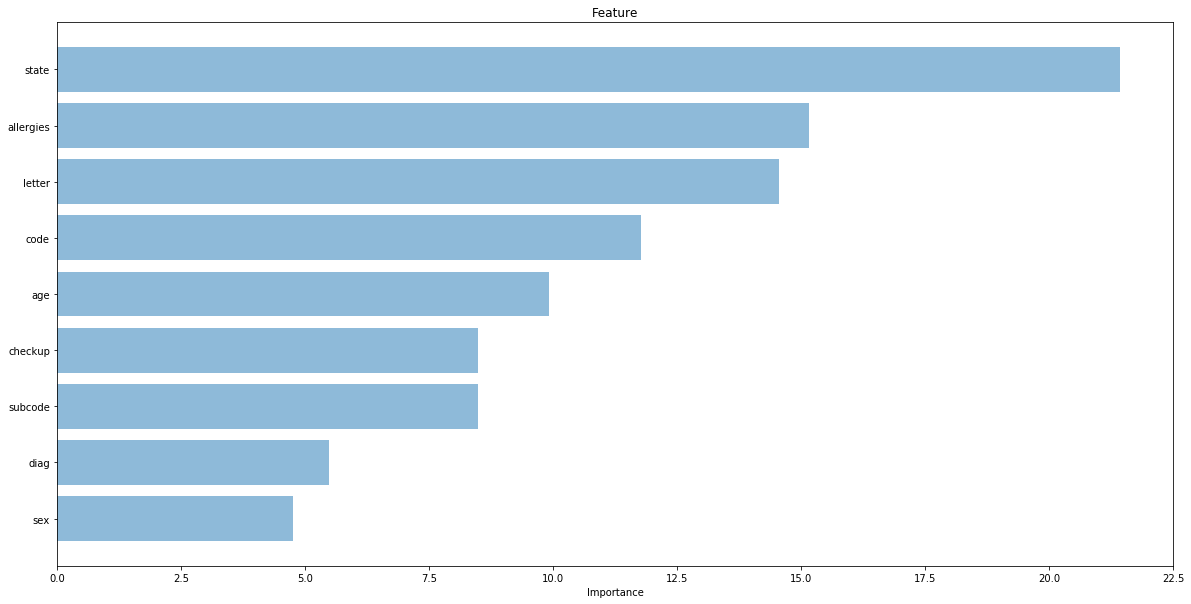

In [36]:
draw_importance(X_train.columns, model.feature_importances_, save_path=None)

## Submission

In [37]:
# sdf = pd.DataFrame(tdf.index, columns=['ID'])
# Xm_test, Xj_test = mj_split(X_test)
# Xm_test.shape, Xj_test.shape

In [38]:
# proba = pd.DataFrame(np.hstack((modelm.predict_proba(Xm_test)[:, 1], modelj.predict_proba(Xj_test)[:, 1])),
#                      index=np.hstack((np.array(list(Xm_test.index)), np.array(list(Xj_test.index)))),
#                      columns=['proba'])
# sdf = pd.concat([sdf, proba], axis=1)
# sdf.head()

In [39]:
sdf = pd.DataFrame(tdf.index, columns=['ID'])
sdf['proba'] = model.predict_proba(X_test)[:, 1]
sdf.head()

,ID,proba
0,0,0.924823
1,1,0.879103
2,2,0.695158
3,3,0.955137
4,4,0.667362


In [40]:
sdf.to_csv(SUBMISSION_PATH, index=False)